In [1]:
# Usual imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics to help get counts 
from sklearn import metrics

# Credentials to pull data
from env import get_db_url

# Splitter
from prep import get_proportional_splits

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
# Pull data from Codeup MySQL server

url = get_db_url('logs')
df = pd.read_sql('SELECT * FROM api_access', url)
df.to_csv('api_access.csv', index=False)

In [2]:
import os

def get_api_access_logs():
    filename = 'api_access.csv'
    if os.path.exists(filename):
        print('Reading from CSV file...')
        return pd.read_csv(filename)
    
    print('Getting a fresh copy from SQL db...')
    query = 'SELECT * FROM api_access'
    url = get_db_url('logs')
    df = pd.read_sql(query, url)
    print('Copying file to CSV...')
    df.to_csv(filename, index=False)
    return df
    

In [3]:
df = get_api_access_logs()

Getting a fresh copy from SQL db...
Copying file to CSV...


In [4]:
# Look at data
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13974 entries, 0 to 13973
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   entry   13974 non-null  object
dtypes: object(1)
memory usage: 109.3+ KB


,entry
0,"97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ""GET /api/v1/sales?page=81 HTTP/1.1"" 200..."
1,"97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ""GET /api/v1/items HTTP/1.1"" 200 3561 ""-..."
2,"97.105.19.58 - - [16/Apr/2019:19:34:44 +0000] ""GET /api/v1/sales?page=82 HTTP/1.1"" 200..."
3,"97.105.19.58 - - [16/Apr/2019:19:34:46 +0000] ""GET /api/v1/sales?page=83 HTTP/1.1"" 200..."
4,"97.105.19.58 - - [16/Apr/2019:19:34:48 +0000] ""GET /api/v1/sales?page=84 HTTP/1.1"" 200..."


In [6]:
# Start pulling string apart into workable columns

entry = df.entry[0]
parts = entry.split()

output = {}

output['ip'] = parts[0][1:]
output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
output['request_method'] = parts[5][1:]
output['endpoint'] = parts[6]
output['http_version'] = parts[7][:-1]
output['status_code'] = parts[8]
output['byte_size'] = int(parts[9])
output['user_agent'] = ' '.join(parts[11:]).replace('"', '')


output



{'ip': '7.105.19.58',
 'timestamp': '16/Apr/2019 19:34:42',
 'request_method': 'GET',
 'endpoint': '/api/v1/sales?page=81',
 'http_version': 'HTTP/1.1',
 'status_code': '200',
 'byte_size': 512495,
 'user_agent': 'python-requests/2.21.0'}

In [5]:
# Make a function to apply to the df (to make those workable columns)
def api_log_parser(entry):
    parts = entry.split()

    output = {}

    output['ip'] = parts[0][1:]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['endpoint'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['byte_size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

In [6]:
# Apply function to the df
df = df.entry.apply(api_log_parser)

In [7]:
# Check new df
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13974 entries, 0 to 13973
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13974 non-null  object
 1   timestamp       13974 non-null  object
 2   request_method  13974 non-null  object
 3   endpoint        13974 non-null  object
 4   http_version    13974 non-null  object
 5   status_code     13974 non-null  object
 6   byte_size       13974 non-null  int64 
 7   user_agent      13974 non-null  object
dtypes: int64(1), object(7)
memory usage: 873.5+ KB


,ip,timestamp,request_method,endpoint,http_version,status_code,byte_size,user_agent
0,7.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,7.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,7.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,7.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,7.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [8]:
df.describe()

,byte_size
count,13974.000000
mean,449900.797338
std,160742.535606
min,0.000000
25%,500637.000000
50%,510138.000000
75%,511291.000000
max,513736.000000


In [9]:
#Set timestamp to datetime
df.timestamp = pd.to_datetime(df.timestamp)
#Set timestamp as index
df = df.set_index(df.timestamp)
#Drop old timestamp column
df = df.drop(columns = ['timestamp'])
#Check df
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13974 entries, 2019-04-16 19:34:42 to 2019-04-17 12:55:14
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13974 non-null  object
 1   request_method  13974 non-null  object
 2   endpoint        13974 non-null  object
 3   http_version    13974 non-null  object
 4   status_code     13974 non-null  object
 5   byte_size       13974 non-null  int64 
 6   user_agent      13974 non-null  object
dtypes: int64(1), object(6)
memory usage: 873.4+ KB


,ip,request_method,endpoint,http_version,status_code,byte_size,user_agent
timestamp,,,,,,,
2019-04-16 19:34:42,7.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
2019-04-16 19:34:42,7.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2019-04-16 19:34:44,7.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
2019-04-16 19:34:46,7.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
2019-04-16 19:34:48,7.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


<AxesSubplot:>

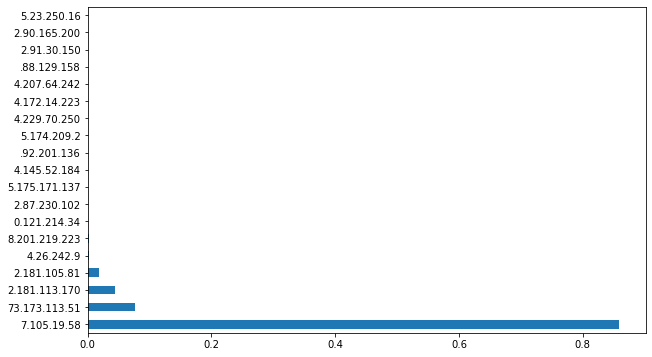

In [13]:
#View percentages of IP addresses
df.ip.value_counts(normalize=True).plot.barh(figsize= (10,6))

In [16]:
# View requests
df.request_method.value_counts()

GET    13974
Name: request_method, dtype: int64

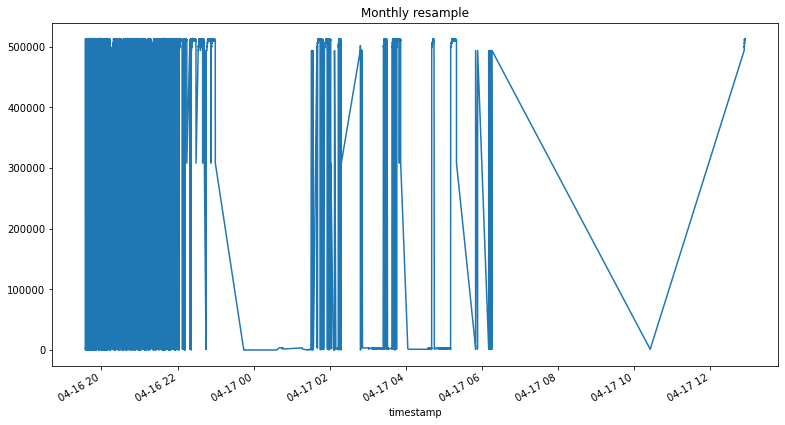

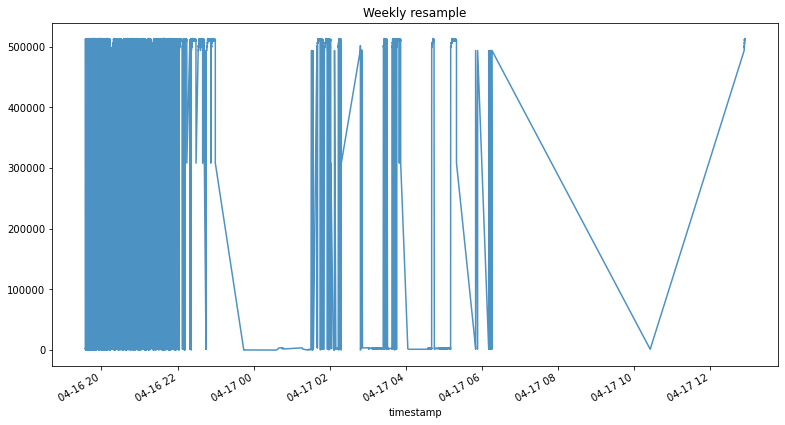

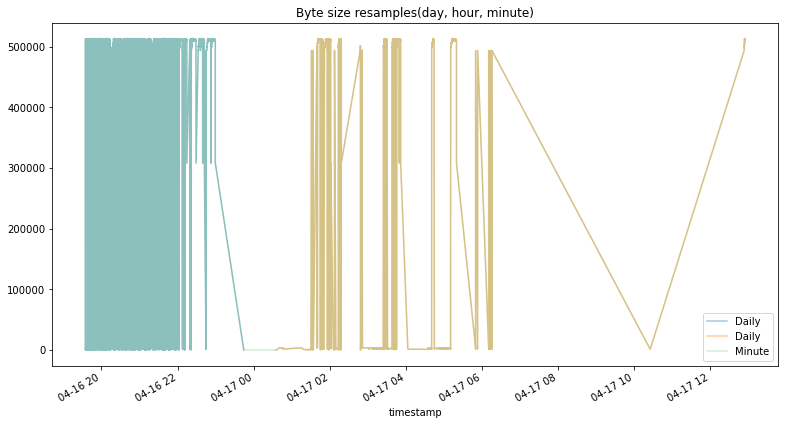

In [29]:
plt.figure(figsize=(13,7))
df.resample('M').byte_size.plot(label='Monthly')
plt.title('Monthly resample')
plt.show()

plt.figure(figsize=(13,7))
df.resample('W').byte_size.plot(alpha=.8, label='Weekly')
plt.title('Weekly resample')
plt.show()

plt.figure(figsize= (13,7))
df.resample('D').byte_size.plot(alpha=.4, label='Daily')
#df.resample('H').byte_size.plot(alpha=.6, label='Hourly')
df.resample('M').byte_size.plot(alpha=.2, label='Minute')
plt.title('Byte size resamples(day, hour, minute)')
plt.legend()

In [26]:
pd.set_option('display.max_rows', 250)
print(df.endpoint.value_counts(normalize=True).sort_index())

/                                          0.007657
/api/V1/HiZach!                            0.000072
/api/v1                                    0.000072
/api/v1/                                   0.000286
/api/v1//api/v1/items                      0.000072
/api/v1//api/v1/items/next_page            0.000072
/api/v1//api/v1/items?page=2               0.000716
/api/v1/I_DIDNT_DO_IT!!!!                  0.000072
/api/v1/helloclass!                        0.000072
/api/v1/items                              0.033205
/api/v1/items&page=0                       0.000072
/api/v1/items/api/v1/items?page=2          0.000429
/api/v1/items/api/v1/items?page=3          0.000072
/api/v1/items/next_page                    0.000358
/api/v1/items?page=0                       0.000072
/api/v1/items?page=1                       0.006297
/api/v1/items?page=2                       0.020824
/api/v1/items?page=3                       0.015672
/api/v1/items?page=4                       0.000072
/api/v1/item

In [23]:
#Zero bytes
df[df.byte_size == 0]

,ip,request_method,endpoint,http_version,status_code,byte_size,user_agent
timestamp,,,,,,,
2019-04-16 19:55:15,7.105.19.58,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.20.1
2019-04-16 19:56:02,7.105.19.58,GET,/api/v1/sales?page=21,HTTP/1.1,499,0,python-requests/2.20.1
2019-04-16 20:28:46,7.105.19.58,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.21.0
2019-04-16 20:33:24,7.105.19.58,GET,/api/v1/sales?page=29,HTTP/1.1,499,0,python-requests/2.21.0
2019-04-16 20:38:13,7.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0
2019-04-16 20:38:55,7.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0
2019-04-16 20:39:00,7.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0
2019-04-16 20:45:17,7.105.19.58,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0
2019-04-16 20:45:28,7.105.19.58,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.21.0
